# Training (small) model build on CoreX topic model

### Requirements

In [1]:
from typing import Tuple
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torchmetrics import Accuracy, SpearmanCorrcoef
from tqdm.notebook import tqdm

from utils import corex_probs_factory, syntax_factory

data_dir = Path("/home/iailab36/iser/data/stsbenchmark")
model_dir = Path("/home/iailab36/iser/models")

/home/iai/user/iser/.conda/envs/main/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Load benchmark dataset
train_data = pd.read_feather(data_dir / "sts-train.feather")
val_data = pd.read_feather(data_dir / "sts-dev.feather")

## Pre-compute features

In [3]:
features_train = []
features_val = []

### topic model features

In [4]:
get_topic_probs = corex_probs_factory(
    corex_path=model_dir / "corex-sts-300",
    vectorizer_path=model_dir / "vectorizer-sts-10000",
)

In [5]:
# compute topic probabilities
topic_probs_train_1 = get_topic_probs(train_data.s1)
topic_probs_train_2 = get_topic_probs(train_data.s2)
topic_probs_val_1 = get_topic_probs(val_data.s1)
topic_probs_val_2 = get_topic_probs(val_data.s2)
# concatenate topics of the two sentences
topic_probs_train = np.concatenate([topic_probs_train_1, topic_probs_train_2], axis=1)
topic_probs_val = np.concatenate([topic_probs_val_1, topic_probs_val_2], axis=1)
# add to features list
features_train.append(topic_probs_train)
features_val.append(topic_probs_val)

### syntax features

In [6]:
# get_syntax_deps = syntax_factory()
# # compute syntax tokens
# syntax_train_1 = get_syntax_deps(train_data.s1)
# syntax_train_2 = get_syntax_deps(train_data.s2)
# syntax_val_1 = get_syntax_deps(val_data.s1)
# syntax_val_2 = get_syntax_deps(val_data.s2)
# # mask matching syntax
# syntax_train = (syntax_train_1 == syntax_train_2).astype(int)
# syntax_val = (syntax_val_1 == syntax_val_2).astype(int)
# # append to features list
# features_train.append(syntax_train)
# features_val.append(syntax_val)

## Training without data augmentation

In [7]:
# create input vectors
X_train = torch.FloatTensor(np.concatenate(features_train, axis=1))
X_val = torch.FloatTensor(np.concatenate(features_val, axis=1))
# create targets
y_train = torch.FloatTensor(train_data.score)
y_val = torch.FloatTensor(val_data.score)

In [8]:
train_dataloader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(list(zip(X_val, y_val)), batch_size=256)

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class SimilarityModel(nn.Module):
    def __init__(self, layers: Tuple[int]):
        super().__init__()
        # main net
        self.layers = nn.ModuleList([nn.Linear(in_feat, out_feat) for in_feat, out_feat in zip(layers[:-1], layers[1:])])
        # initialize
        self.layers.apply(init_weights)

    def forward(self, x) -> torch.Tensor:
        # feed through all layers
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        # last layer without activation
        return self.layers[-1](x).squeeze()

In [10]:
model = SimilarityModel(layers=(X_train.shape[1], 512, 256, 1))
x, y_hat = next(iter(train_dataloader))
model(x).shape

torch.Size([64])

In [14]:
N_STEPS = 8_000
V_INTERVAL = 20

model = SimilarityModel(layers=(X_train.shape[1], 512, 512, 256, 128, 64, 1))
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
metric = SpearmanCorrcoef()

train_losses, train_spearman = [], []
test_losses, test_spearman = [], []
running_loss = 0
step = 0

# training
with tqdm(total=N_STEPS) as pbar:
    while step < N_STEPS:
        for x, y_hat in train_dataloader:
            # increase step
            step += 1
            if step > N_STEPS:
                break
            # compute embeddings for both input sentences
            y = model(x)
            # compute loss
            loss = criterion(y, y_hat)
            # loss, metric tracking
            running_loss += loss.item()
            metric(y, y_hat)
            # optimizer step
            optim.zero_grad()
            loss.backward()
            optim.step()

            # metric logging
            if step % V_INTERVAL == 0:
                # Test epoch
                with torch.no_grad():
                    y, y_hat = [*zip(*[(model(x), y_hat) for x, y_hat in val_dataloader])]
                y = torch.cat(y)
                y_hat = torch.cat(y_hat)
                # append metrics
                train_losses.append(running_loss / V_INTERVAL)
                train_spearman.append(metric.compute())
                test_losses.append(criterion(y, y_hat))
                test_spearman.append(metric(y, y_hat))
                # reset tracking
                running_loss = 0
                metric.reset()
                # update progress bar
                pbar.set_postfix({"loss": train_losses[-1], "train": train_spearman[-1], "test": test_spearman[-1]})

            pbar.update()

/home/iai/user/iser/.conda/envs/main/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/8000 [00:00<?, ?it/s]

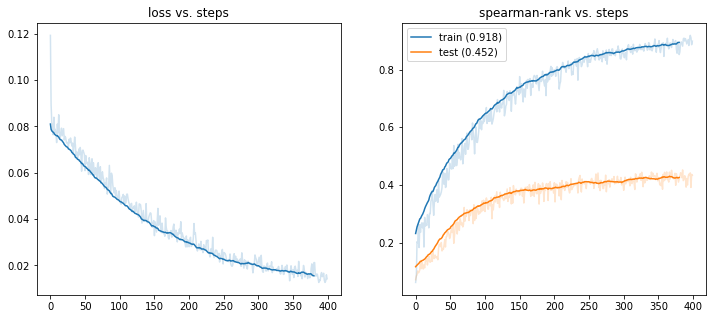

In [15]:
N = 20
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses, color="tab:blue", alpha=0.2)
ax[0].plot(pd.Series(train_losses).rolling(window=N).mean().iloc[N-1:].values, color="tab:blue")
ax[0].set_title("loss vs. steps")
ax[1].plot(train_spearman, color="tab:blue", alpha=0.2)
ax[1].plot(pd.Series(train_spearman).rolling(window=N).mean().iloc[N-1:].values, color="tab:blue", label=f"train ({max(train_spearman):.3f})")
ax[1].plot(test_spearman, color="tab:orange", alpha=0.2)
ax[1].plot(pd.Series(test_spearman).rolling(window=N).mean().iloc[N-1:].values, color="tab:orange", label=f"test ({max(test_spearman):.3f})")
ax[1].set_title("spearman-rank vs. steps")
ax[1].legend()
plt.show()

## Analyse Performance

In [13]:
# score test dataset
with torch.no_grad():
    y, y_hat = [*zip(*[(model(featA, featB), score) for featA, featB, score in val_dataloader])]
y = torch.cat(y)
y_hat = torch.cat(y_hat)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
df = data_module.intermediates["test"].copy().drop(columns="score")
df[["root", "nsubj", "dobj"]] = df[["feat1", "feat2"]].apply(lambda row: pd.Series((row.feat1[1] == row.feat2[1]).long()), axis=1)
df = df.drop(columns=["feat1", "feat2"])
df["y"] = y
df["y_hat"] = y_hat
df

In [ ]:
df[(df.y_hat - df.y) > 0.5]

In [ ]:
((df.root & df.nsubj).astype(int) == df.y_hat).sum() / len(df)

In [ ]:
df["y_"] = (df.root | df.nsubj).astype(int)
df

In [ ]:
words = list(np.asarray(corex_feat.vectorizer.get_feature_names_out()))
corex_feat.corex.set_words(words)
topics = [[*zip(*topic)][0] for topic in corex_feat.corex.get_topics()]

In [ ]:
feat1, feat2 = [*zip(*[(feat1[0], feat2[0]) for feat1, feat2, _ in val_dataloader])]
feat1 = torch.cat(feat1).softmax(-1)
feat2 = torch.cat(feat2).softmax(-1)
feat1.shape

In [ ]:
for t in topics:
    if "football" in t:
        print(t)

In [ ]:
df[(df.y_hat - df.y).abs() > 0.5].head()

### Naive cosine similarity

In [ ]:
import spacy
nlp = spacy.load("en_core_web_lg", exclude=["ner"])

In [ ]:
df["naive"] = df[["s1", "s2"]].apply(lambda row: nlp(row.s1).similarity(nlp(row.s2)), axis=1)
df[(df.y_hat - df.y).abs() > 0.5].head()

In [ ]:
print(SpearmanCorrcoef()(torch.FloatTensor(df.naive), torch.FloatTensor(df.y_hat)).item())

In [ ]:
doc = nlp("A woman measures another woman's ankle.")
print([token.dep_ for token in doc])
print([token.lemma_ for token in doc])